## Library Imports

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import requests
import xlsxwriter
import math

## Stock Imports

In [2]:
symbols = pd.read_csv('sp500_symbols.csv', skiprows=1, header=None)[0].tolist()

## Download Historical Data

In [3]:
all_data = {}
for symbol in symbols:
    try:
        data = yf.download(symbol, start="2023-01-01", end="2024-01-01")['Adj Close']
        if not data.empty:
            all_data[symbol] = data
    except Exception as e:
        print(f"Failed download for {symbol}: {e}")

all_data_df = pd.DataFrame(all_data)  # Convert the dictionary to a DataFrame
all_data_df = all_data_df.dropna(axis=1, how='all')  # Drop columns with missing values

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[***

$CAT: possibly delisted; No price data found  (1d 2023-01-01 -> 2024-01-01)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$BF.B: possibly delisted; No price data found  (1d 2023-01-01 -> 2024-01-01)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SOLV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1672549200, endDate = 1704085200")
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*********************

## Calculate Equal Weights For Each Stock

In [4]:
num_stocks = all_data_df.shape[1]
equal_weights = 1 / num_stocks

## Calculate Daily Returns For Each Stock

In [5]:
daily_returns = all_data_df.pct_change().dropna()

## Fetching Stock Data using yfinance

In [6]:
def get_stock_info(symbol):
    stock = yf.Ticker(symbol)
    info = stock.info
    market_cap = info.get('marketCap', 'N/A')
    price = info.get('currentPrice', 'N/A')
    return market_cap, price

data_list = [] # List to collect data

valid_symbols = list(all_data.keys()) # Fetch data for each valid stock
for symbol in valid_symbols:
    try:
        market_cap, price = get_stock_info(symbol)
        data_list.append({'Ticker': symbol, 'Price': price, 'Market Capitalization': market_cap, 'Number Of Shares to Buy': 'N/A'})
    except Exception as e:
        print(f"Failed to get info for {symbol}: {e}")

final_dataframe = pd.DataFrame(data_list)
final_dataframe

,Ticker,Price,Market Capitalization,Number Of Shares to Buy
0,AAPL,208.3729,3168122437632,N/A
1,MSFT,392.5900,2918137200640,N/A
2,NVDA,96.8100,2381361446912,N/A
3,AMZN,158.1600,1659984019456,N/A
4,META,463.4600,1172470366208,N/A
...,...,...,...,...
492,AAL,9.2380,6066631680,N/A
493,BEN,21.1000,11035257856,N/A
494,PARA,10.6800,7574021120,N/A
495,FOX,33.8900,16363278336,N/A


## Calculate Portfolio Returns

In [7]:
weighted_returns = daily_returns * equal_weights
portfolio_returns = weighted_returns.sum(axis=1)
cumulative_returns = (1 + portfolio_returns).cumprod()

## Plot Cumulative Returns

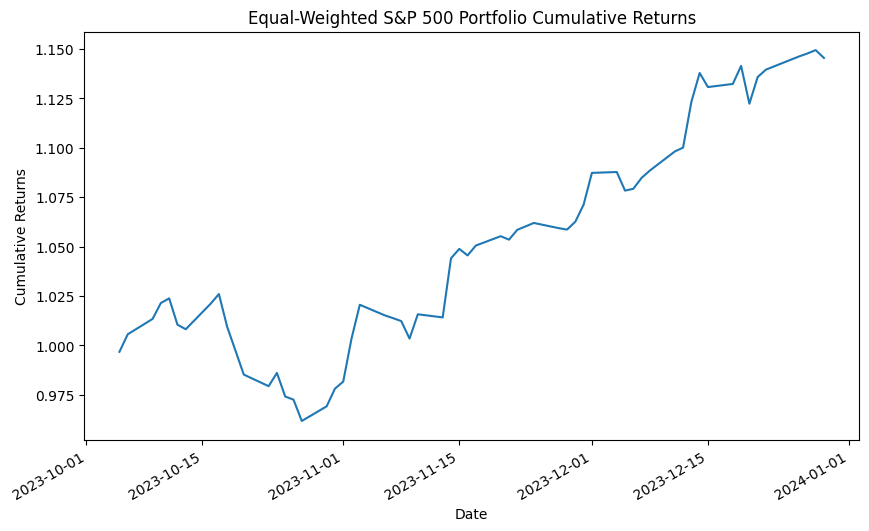

In [8]:
plt.figure(figsize=(10, 6))
cumulative_returns.plot()
plt.title('Equal-Weighted S&P 500 Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

## Input for Portfolio Size

In [9]:
while True:
    portfolio_size = input("Enter the value of your portfolio:")
    try:
        val = float(portfolio_size)
        break
    except ValueError:
        print("That's not a number! \nTry again:")

Enter the value of your portfolio: 10000


## Calculate Number of Shares to Buy

In [10]:
position_size = val / len(final_dataframe.index)
for i in range(len(final_dataframe)):
    final_dataframe.loc[i, 'Number Of Shares to Buy'] = math.floor(position_size / final_dataframe['Price'][i])
# Filter out stocks which are not bought
final_dataframe = final_dataframe[final_dataframe['Number Of Shares to Buy'] > 0]

## Create Final DataFrame

In [12]:
writer = pd.ExcelWriter('recommended_trades.xlsx', engine='xlsxwriter')
final_dataframe.to_excel(writer, sheet_name='Recommended Trades', index=False)

## Create and Apply Formats

In [ ]:
background_color = '#ffffff'
font_color = '#000000'

string_format = writer.book.add_format(
    {'font_color': font_color, 'bg_color': background_color, 'border': 1}
)

dollar_format = writer.book.add_format(
    {'num_format': '$0.00', 'font_color': font_color, 'bg_color': background_color, 'border': 1}
)

integer_format = writer.book.add_format(
    {'num_format': '0', 'font_color': font_color, 'bg_color': background_color, 'border': 1}
)

column_formats = {
    'A': ['Ticker', string_format],
    'B': ['Price', dollar_format],
    'C': ['Market Capitalization', dollar_format],
    'D': ['Number Of Shares to Buy', integer_format]
}

for column in column_formats.keys():
    writer.sheets['Recommended Trades'].set_column(f'{column}:{column}', 20, column_formats[column][1])
    writer.sheets['Recommended Trades'].write(f'{column}1', column_formats[column][0], string_format)

## Save Excel Output

In [ ]:
writer.close()